# Exploring DEA Fractional Cover 

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls_fc_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls_fc_3), 
[ga_ls_wo_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls_wo_3)


## Ackowledgement


This notebook was built based on DEA's [**Introduction to Fractional Cover**](https://docs.dea.ga.gov.au/notebooks/DEA_datasets/DEA_Fractional_Cover.html)  

## Description
This notebook will demonstrate how to load DEA Fractional Cover using Digital Earth Australia. 
Topics covered include:

1. Loading DEA Fractional Cover for an example location
2. Plotting fractional cover as false colour images
4. Masking out missing or invalid data and unclear or wet pixels, and using this to track percentages of green and brown vegetation and bare soil over time
5. Creating seasonal composites similar to those available in TERN, and exporting/downloading a Seasonal Fractional Cover geoTIFF. 

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 
Under the current

### Load packages
Import Python packages that are used for the analysis.

In [21]:
import datacube
from datacube.utils import masking
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import wofs_fuser
from dea_tools.plotting import rgb, plot_wo
from dask_gateway import Gateway
from dea_tools.dask import create_local_dask_cluster

# Input the coordinates of your region of interest

In [22]:
# Set up a region of interest to load data, you can leave the default if you like.


lat = -31.095

long = 141.775




## You can now run the rest of the notebook. 

#### Open the 'run' menu and click on 'Run Selected Cell and All Below'

### Connect to the datacube

Connect to the datacube so we can access DEA data. 

In [23]:
dc = datacube.Datacube(app='DEA_Fractional_Cover')

## Available products and measurements

### List products available in Digital Earth Australia
We can use datacube's `list_products` functionality to inspect DEA Fractional Cover products that are available in Digital Earth Australia.
The table below shows the product name that we will use to load data, and a brief description of the product.

In [24]:
# List DEA Fractional Cover products available in DEA
dc_products = dc.list_products()
dc_products.loc[['ga_ls_fc_3']]

name                                        description  \
name                                                                        
ga_ls_fc_3  ga_ls_fc_3  Geoscience Australia Landsat Fractional Cover ...   

              license default_crs default_resolution  
name                                                  
ga_ls_fc_3  CC-BY-4.0        None               None

## Loading data
Now that we know what products and measurements are available for the products, we can load data from Digital Earth Australia for an example location:

#### Let's create a dask cluster to allow parallel processing and load data more efficiently.

In [25]:
client = create_local_dask_cluster(return_client=True)

<Client: 'tcp://127.0.0.1:40737' processes=1 threads=2, memory=12.21 GiB>

In [26]:
#Set up query with location, temporal and dask settings

query = {
    'y': (lat+0.025, lat-0.025),
    'x': (long-0.025, long+0.025),
    'time': ('2015-12-01', '2017-11-30'),
    'dask_chunks': {"time": 30, "x": 62, "y": 52}
}



# Load DEA Fractional Cover data from the datacube
fc = dc.load(product='ga_ls_fc_3',
             measurements=['bs', 'pv', 'npv'],
             output_crs='EPSG:32754',
             resolution=(-30, 30),
             group_by='solar_day',
             **query)

We can now view the data that we loaded.
The measurements listed under `Data variables` should match the measurements displayed in the previous [List measurements](#List-measurements) step.

In [27]:
fc

<xarray.Dataset>
Dimensions:      (time: 88, y: 187, x: 161)
Coordinates:
  * time         (time) datetime64[ns] 2015-12-07T00:27:36.516151 ... 2017-11...
  * y            (y) float64 6.562e+06 6.562e+06 ... 6.557e+06 6.557e+06
  * x            (x) float64 5.715e+05 5.715e+05 ... 5.763e+05 5.763e+05
    spatial_ref  int32 32754
Data variables:
    bs           (time, y, x) uint8 dask.array<chunksize=(30, 52, 62), meta=np.ndarray>
    pv           (time, y, x) uint8 dask.array<chunksize=(30, 52, 62), meta=np.ndarray>
    npv          (time, y, x) uint8 dask.array<chunksize=(30, 52, 62), meta=np.ndarray>
Attributes:
    crs:           EPSG:32754
    grid_mapping:  spatial_ref

### Plotting data
<img align="right" src="../Supplementary_data/DEA_Fractional_Cover/fc_legend.jpg" alt="Fractional cover ternary diagram">

We can plot each FC variable in our dataset (i.e. `['bs', 'pv', 'npv']`) using the `rgb` function. 
This will create a false colour view of the data where shades of green, blue and red represent varying proportions of vegetation and bare soil cover:

* Green: green vegetation (`pv`)
* Blue: brown (i.e. 'non-green') vegetation (`npv`)
* Red: bare soil (`bs`)




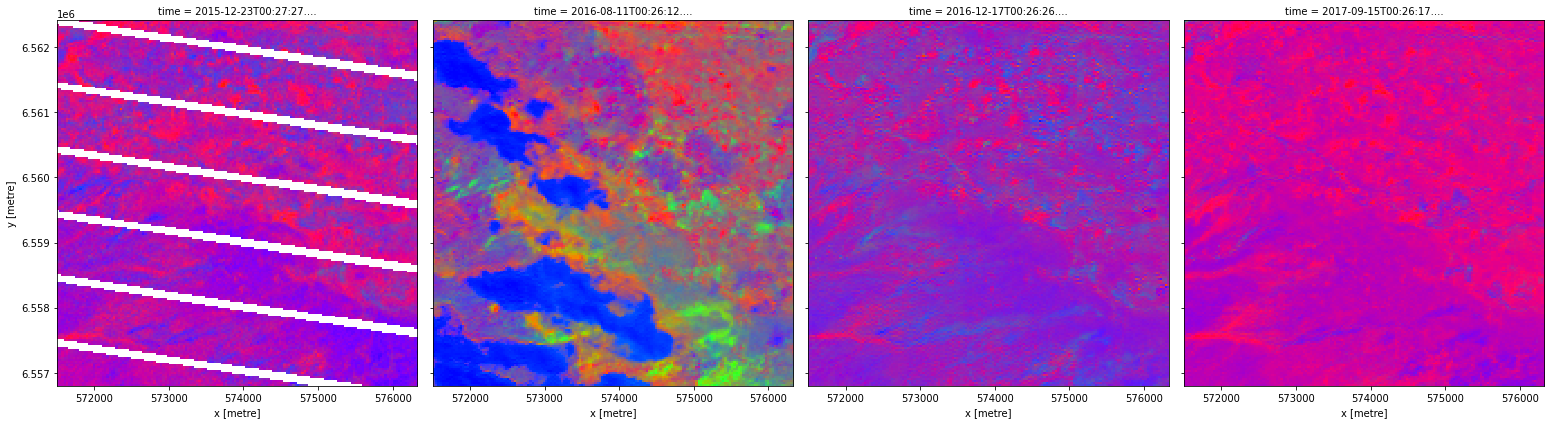

In [28]:
# Plot DEA Fractional Cover data as a false colour RGB image (takes 2' to load)
rgb(fc, bands=['bs', 'pv', 'npv'], index=[2, 30, 45, 78], percentile_stretch=(0.05, 0.95))

> **Note:** For more technical information about the accuracy and limitations of DEA Fractional Cover, refer to the Details tab of the official [Geoscience Australia DEA Fractional Cover product description](https://cmi.ga.gov.au/data-products/dea/629/dea-fractional-cover-landsat#details).

## Example application: tracking changes in vegetation cover and bare soil over time
The following section will demonstrate a simple analysis workflow based on DEA Fractional Cover. 
In this example, we will process our loaded FC data so that we can consistently track the changing proportions of green vegetation, brown vegetation and bare soil over time.


### Setting nodata
As the first step in our analysis, we need to set nodata pixels to `NaN`. This ensures that missing data is dealt with correctly in any future calculations.

In [29]:
# Replace all nodata values with `NaN`
fc = masking.mask_invalid_data(fc)

### Applying a cloud and water mask
In the images we plotted earlier, you may have noticed the third panel is affected by cloud. 
This can cause the fractional cover algorithm to produce misleading results. 
FC will also produce poor results over water, causing erroneous values for green vegetation to appear within wet pixels (e.g. the fourth panel above). 

To track FC reliably over time, we need to remove these potentially inaccurate pixels. 
One of the easiest ways to do this is to load data from the [DEA Water Observations](DEA_Water_Observations.ipynb) product that identifies wet and unclear pixels (e.g. cloud or cloud shadow) in the landscape.

In the next cell, we load DEA Water Observations data into the extents of our DEA Fractional Cover data using `dc.load()`'s `like` argument.

> **Note:** For more details about loading data, refer to the 'Introduction to loading data' notebook located in Beginners_guide folder.

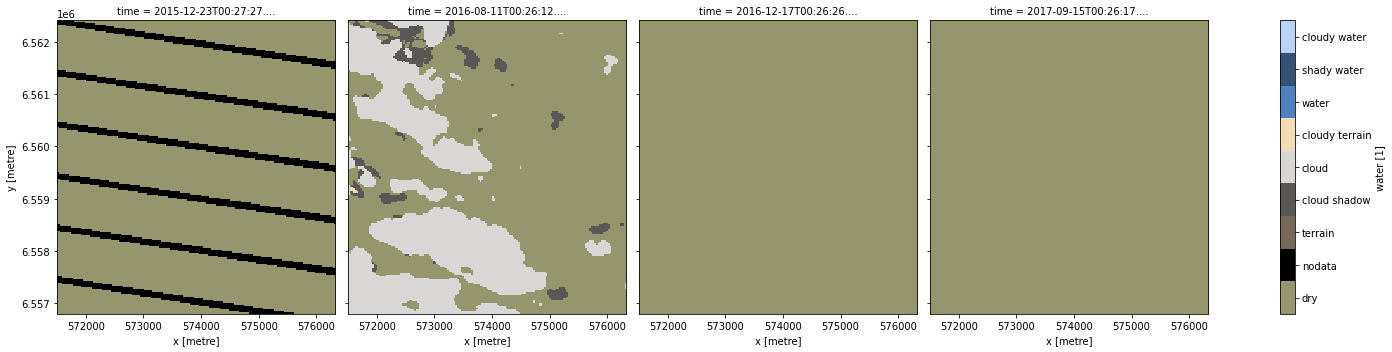

In [30]:
# Load DEA Water Observations data from the datacube
wo = dc.load(product='ga_ls_wo_3',
             group_by='solar_day',
             fuse_func=wofs_fuser,
             like=fc)

wo_subset = wo.isel({'time':[1, 29, 43, 75]})

# Plot the loaded water observations
plot_wo(wo_subset.water, col='time', size=5)

This plot shows that all images contain water, and the third image contains large amounts of cloud and cloud shadow. To remove these pixels, we first create a binary mask where `True` (yellow) represents clear and dry pixels, and `False` (purple) represents wet, cloudy or shadowy pixels.

> **Note:** For a detailed guide to using DEA Water Observations data to mask data, see the DEA_Water_Observations.ipynb notebook in DEA_datasets folder.

In [31]:
# Keeping only dry, non-cloudy pixels
wo_mask = masking.make_mask(wo.water, dry=True)

Using this mask, we can now remove any wet and unclear pixels from our original DEA Fractional Cover data. 
Note that these pixels now appear white as they have been replaced with `NaN`.

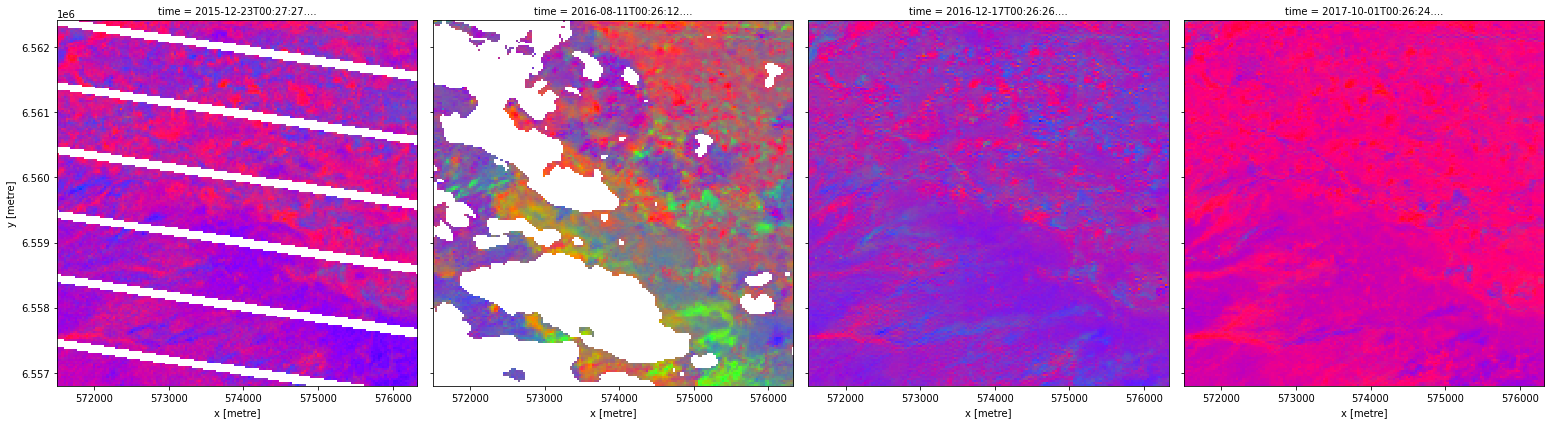

In [32]:
#This cell takes 3' to run

# Set any unclear or wet pixel to `NaN`
fc_masked = fc.where(wo_mask)

# Plot the masked fractional cover data
rgb(fc_masked, bands=['bs', 'pv', 'npv'], index=[1, 29, 42, 75])

### Dropping poorly observed scenes
In the image above, we can see that the third observation was mostly obscured by cloud, leaving very little usable data. 
So that this doesn't lead to unrepresentative statistics, we can keep only observations that had (for example) less than 50% nodata pixels.

In [33]:
#This cell takes 40" to run

# Calculate the percent of nodata pixels in each observation
percent_nodata = fc_masked.pv.isnull().mean(dim=['x', 'y'])

# Use this to filter to observations with less than 50% nodata
fc_masked = fc_masked.sel(time=percent_nodata < 0.5)

# The data now contains 67 observations
fc_masked

<xarray.Dataset>
Dimensions:      (time: 67, y: 187, x: 161)
Coordinates:
  * time         (time) datetime64[ns] 2015-12-23T00:27:27.867115 ... 2017-11...
  * y            (y) float64 6.562e+06 6.562e+06 ... 6.557e+06 6.557e+06
  * x            (x) float64 5.715e+05 5.715e+05 ... 5.763e+05 5.763e+05
    spatial_ref  int32 32754
Data variables:
    bs           (time, y, x) float64 dask.array<chunksize=(20, 52, 62), meta=np.ndarray>
    pv           (time, y, x) float64 dask.array<chunksize=(20, 52, 62), meta=np.ndarray>
    npv          (time, y, x) float64 dask.array<chunksize=(20, 52, 62), meta=np.ndarray>
Attributes:
    crs:           EPSG:32754
    grid_mapping:  spatial_ref

### Calculating average fractional cover over time
Now that our FC data has had nodata values and cloud, shadow and water pixels set to `NaN` and we have dropped unrepresentative observations, we can reliably track how average proportions of green and brown vegetation and bare soil have changed over time across our entire study area. 
We can then plot this as a line chart, showing that green vegetation (`pv`) has consistently decreased over time at this location, and brown vegetation (`npv`) and bare soil (`bs`) have increased.

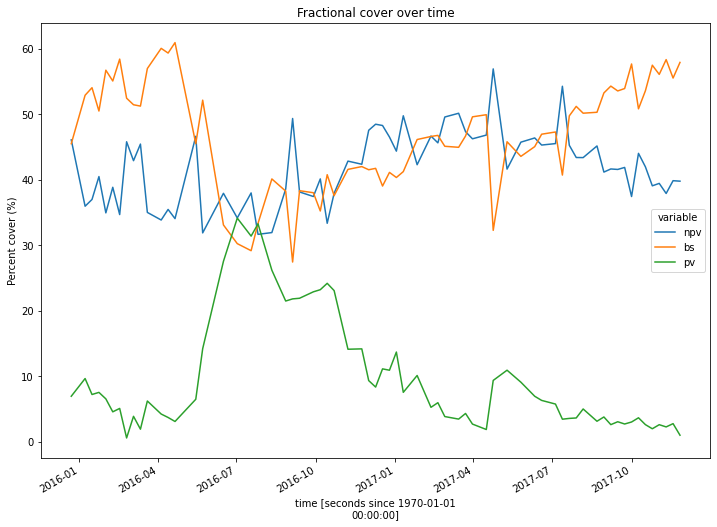

In [34]:
#This cell runs in 2'

# Calculate average fractional cover for `bs`, `pv` and `npv` over time
fc_through_time = fc_masked[['npv', 'bs', 'pv']].mean(dim=['x', 'y'])

# Plot the changing proportions as a line graph
fc_through_time.to_array().plot.line(hue='variable', size=8)
plt.title('Fractional cover over time')
plt.ylabel('Percent cover (%)');

## Seasonal compositing and downloading scenes
The following section will demonstrate a simple functions to create VFC seasonal composites simmilar to the collection avialable in TERN catalogue.
We will also see how we can export and download VFC scenes from the sandbox. 


#### Load packages

Import python packages to be used for this part of the analysis

In [35]:
%matplotlib inline

import numpy as np
from datacube.utils.cog import write_cog
from odc.algo import to_f32, xr_geomedian, int_geomedian
import warnings
warnings.filterwarnings('ignore')
from odc.ui import with_ui_cbk

#### Use DEA's geomedian function to create seasonal composites

We'll take 1 year of our filtered timeseries of DEA Fractional Cover and regroup it into seasons for compositing

In [36]:
# This cell runs in 3.5'

#Subset to 1 year of data

fc_masked_1y = fc_masked.sel(time=slice("2016-06-01", "2017-05-30"))

#Regroup the data
seasongroup = fc_masked_1y.groupby('time.season')

#Set up the geomedian computer
comp_object = seasongroup.map(int_geomedian)

#Run the computation
seasonal_FCcomp = comp_object.compute()


> **Note:** For a detailed guide to using DEA Geomedian functions, see the Generating_geomedian_composites notebook located in Frequently_used_code folder.

### Let's plot our seasonal composites and see what they look like

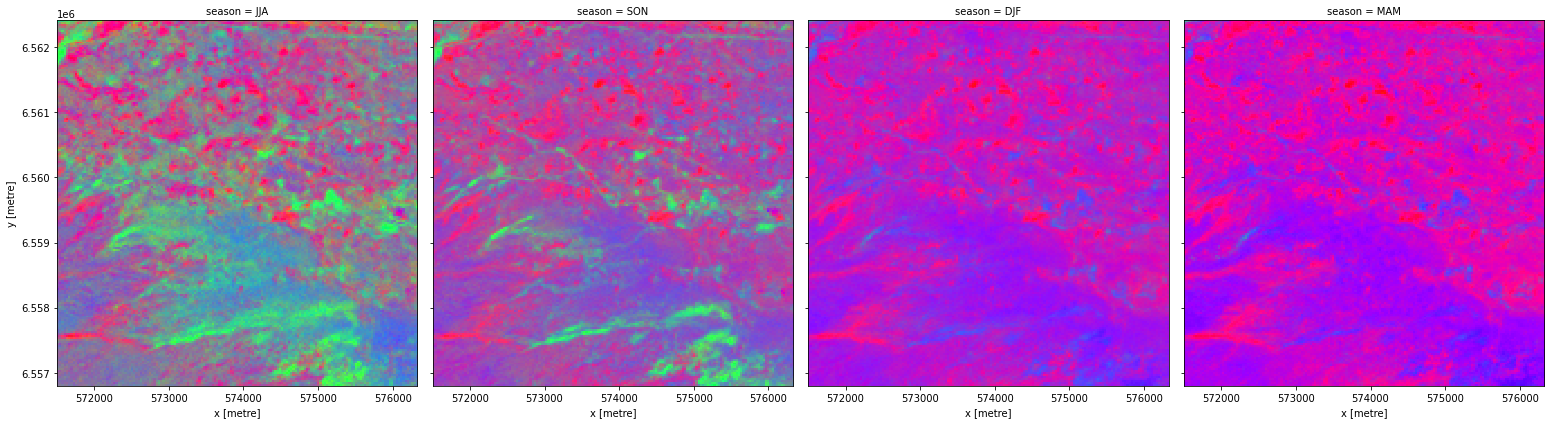

In [37]:
# Plot DEA Fractional Cover data as a false colour RGB image
rgb(seasonal_FCcomp, bands=['bs', 'pv', 'npv'], index_dim='season', index=[1, 3, 0, 2])

### Now we can export the seasonal composite we want

In [38]:
#Select the composite image we want to export 

selected_timestep = seasonal_FCcomp.isel(season=1).to_array()

# Write multi-band GeoTIFF to a location
write_cog(geo_im=selected_timestep,
          fname='seasonal_composite.tif',
          overwrite=True)

PosixPath('seasonal_composite.tif')

#### After the last cell runs, we can find our Seasonal composite GeoTIFF in the File Browser panel.

To free up computing resources for future work, we can close the Dask client once we are finished:

In [39]:
client.close()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2021

**Compatible datacube version:** 

In [40]:
print(datacube.__version__)

1.8.6


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)